In [ ]:
# DATA

import pandas as pd
import stan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

# stan problems
import nest_asyncio
nest_asyncio.apply()

data = pd.read_csv("sample_response_times.csv", sep=';')

data.head()

In [ ]:
stan_code = """
data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

// EVERYTHING ABOVE 0!!!! EVERYTHING!!!!!!
parameters {
    real<lower=0> v_easy;         // Drift rate for easy condition
    real<lower=0> v_hard;         // Drift rate for hard condition
    real<lower=0> a;              // Boundary separation
    real<lower=0, upper=1> beta;  // Starting point bias
    real<lower=0, upper=min(y)> tau;  // Non-decision time with upper bound
}

model {
    // Priors (updated)
    v_easy ~ gamma(1, 2);
    v_hard ~ gamma(1, 2);
    a ~ gamma(2, 0.5);
    beta ~ beta(2, 2);
    tau ~ gamma(1, 10);

    // Likelihood (unchanged)
    for (n in 1:N) {
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a, tau, beta, v_easy);
            } else {
                y[n] ~ wiener(a, tau, 1 - beta, -v_easy);
            }
        }
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                y[n] ~ wiener(a, tau, beta, v_hard);
            } else {
                y[n] ~ wiener(a, tau, 1 - beta, -v_hard);
            }
        }
    }
}
"""

In [ ]:
stan_data = {
    "N": len(data),
    "y": data["rt"].astype(float).values,
    "condition": data["condition"].astype(int).values,
    "choice": data["choice"].astype(int).values
}

model = stan.build(program_code=stan_code, data=stan_data)
fit = model.sample(num_chains=4, num_samples=2000)

# Diagnostics
print(fit)  # R-hat and EES

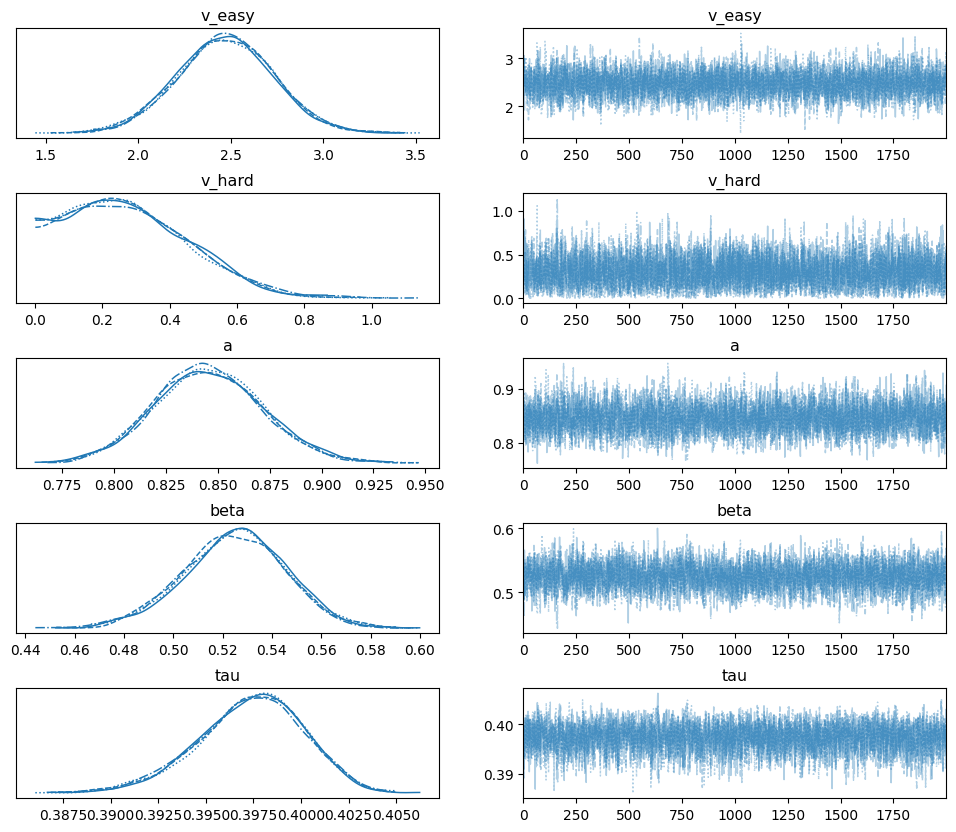

v_easy: mean = 2.47, 95% HDI = [1.96736185 2.98469113]
v_hard: mean = 0.28, 95% HDI = [0.01384723 0.66034203]


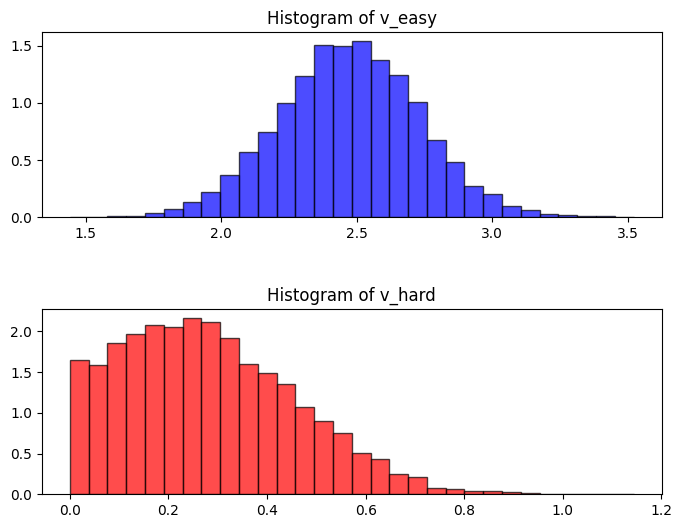

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_easy,2.473,0.259,1.986,2.956,0.004,0.003,4368.0,4627.0,1.0
v_hard,0.281,0.176,0.000,0.580,0.003,0.002,3189.0,2151.0,1.0
a,0.846,0.026,0.798,0.896,0.000,0.000,4027.0,5078.0,1.0
beta,0.525,0.020,0.485,0.562,0.000,0.000,3813.0,4286.0,1.0
tau,0.397,0.003,0.392,0.402,0.000,0.000,3828.0,4132.0,1.0


In [ ]:
# print and graph in a different cell because the stan takes 5 to 10 business centuries to run

v_easy = fit["v_easy"]
v_hard = fit["v_hard"]
a = fit["a"]
beta = fit["beta"]
tau = fit["tau"]

fig = az.plot_trace(fit)
plt.subplots_adjust(hspace=0.5)
plt.savefig('trace_plot.png')
plt.show()

print(
    f"v_easy: mean = {np.mean(v_easy):.2f}, 95% HDI = {np.percentile(v_easy, [2.5, 97.5])}")
print(
    f"v_hard: mean = {np.mean(v_hard):.2f}, 95% HDI = {np.percentile(v_hard, [2.5, 97.5])}")


fig, axes = plt.subplots(2, 1, figsize=(8, 6))  # 2 subplots
axes[0].hist(v_easy.flatten(), bins=30, density=True,
             alpha=0.7, color='blue', edgecolor='black')
axes[0].set_title("Histogram of v_easy")

axes[1].hist(v_hard.flatten(), bins=30, density=True,
             alpha=0.7, color='red', edgecolor='black')
axes[1].set_title("Histogram of v_hard")

plt.subplots_adjust(hspace=0.5)
plt.savefig("drift_rate_histograms.png", bbox_inches='tight')
plt.show()

az.summary(fit)